# Small Language Model from LLM
Download an LLM, prune and quantize it, and benchmark it each step of the way.

## Start by downloading an LLM
I was going to use Llama 2 just because of how ubiquitous it currently is. However, I realized it requires HuggingFace authentication, because of how Meta AI has an approval process. To avoid cluttering the code with authentication, I just went with Mistral AI's Mistral model instead. We could choose larger versions of this model. However, to prove out and practice these model-optimization concepts, we can iterate faster with a smaller model like 7B.

According to a discussion on HuggingFace, Llama-2 7B requires 28GB of GPU RAM. Assuming it is similar for Mistral 7B, and to be on the safe side, I'll over-provision with an ml.g5.4xlarge for my SageMaker Studio Notebook.

### Set up environment
At first I got the error `KeyError: 'mistral'` when running `from_pretrained()`
The solution was on [the model's HuggingFace page](https://huggingface.co/mistralai/Mistral-7B-v0.1#troubleshooting)

I tried installing `evaluate` later in the script, right before using it, but that gave me a warning that a `transformers` process already started. Once I moved the `pip install evaluate` to here, that warning went away.

In [ ]:
!pip install --upgrade datasets evaluate sentence_transformers transformers

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

### Download LLM

In [ ]:
model_repo = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = AutoModelForCausalLM.from_pretrained(model_repo, torch_dtype=torch.float16).to("cuda")

### Verify LLM works

In [4]:
# Simple prompt
prompt = "Write a Haiku explaining biodynamic farming."

In [5]:
# Tokenize the prompt
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

In [ ]:
# Generate response
output = model.generate(input_ids, max_length=35)

In [7]:
# Decode generated text
generated_text = tokenizer.decode(output[0], skip_special_tokens=True) 
print(generated_text)

Write a Haiku explaining biodynamic farming.

The moon is full

The sun is shining bright

The earth is fertile

The moon


## Benchmark FM for baseline
Let's benchmark for accuracy, latency, and resource utilization (Memory, GPU, and CPU).

### Set up environment for evaluations

In [8]:
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained SAS model
sas_model = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')

# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

def compute_sas(predicted_answers, reference_answers):
    """
    Compute the Semantic Answer Similarity (SAS) between a list of predicted answers and reference answers.
    
    Args:
        predicted_answers (list of str): The list of predicted answer texts.
        reference_answers (list of str): The list of reference answer texts.
    
    Returns:
        float: The average SAS score between the predicted and reference answers.
    """
    sas_scores = []
    for predicted, reference in zip(predicted_answers, reference_answers):
        predicted_embedding = sas_model.encode(predicted, convert_to_tensor=True)
        reference_embedding = sas_model.encode(reference, convert_to_tensor=True)
        sas_score = util.cos_sim(predicted_embedding, reference_embedding).item()
        sas_scores.append(sas_score)
    
    return sum(sas_scores) / len(sas_scores)

### Benchmark for Accuracy

In [9]:
from evaluate import load
from datasets import load_dataset

# Load the evaluation metric and dataset
metric = load("accuracy")
dataset = load_dataset("allenai/reward-bench")

In [37]:
def generate_sample(prompt, model, tokenizer, max_new_tokens):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
    attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask.to("cuda")
    
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        # more flexible than max_length, because it only limits output:
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

def generate_predictions(examples):
    predictions = []
    
    for prompt, chosen in zip(examples["prompt"], examples["chosen"]):
        # Generate the model's prediction
        predicted_answer = generate_sample(prompt, model, tokenizer, max_new_tokens=100)
        
        # Append the predicted answer and reference answer to the predictions list
        predictions.append({"predicted": predicted_answer, "reference": chosen})
    
    # Return the predictions
    return {"predictions": predictions}

In [16]:
# See what the dataset looks like.
# Let's treat `prompt` like the Question and `chosen` like the Answer.
dataset["train"][0]

{'prompt': 'What are the names of some famous actors that started their careers on Broadway?',
 'chosen': 'Several famous actors started their careers on Broadway before making it big in film and television. Here are a few notable examples:\n\n1. Sarah Jessica Parker - Before she was Carrie Bradshaw on "Sex and the City," Sarah Jessica Parker was a Broadway star, having appeared in productions like "Annie" as a child.\n\n2. Meryl Streep - Meryl Streep\'s early career included Broadway productions such as "Trelawny of the \'Wells\'" and "A Memory of Two Mondays / 27 Wagons Full of Cotton."\n\n3. Hugh Jackman - Hugh Jackman won a Tony Award for his role in "The Boy from Oz" and has been known for his stage work as well as his film career.\n\n4. Sutton Foster - Known for her television role in "Younger," Sutton Foster is also a Broadway legend with leading roles in shows like "Thoroughly Modern Millie" and "Anything Goes."\n\n5. Kristen Bell - Before she was the voice of Anna in "Frozen" 

We sample a subset of the data, to more quickly get a rough idea if the evaluation works and awards at least some level of accuracy. From a model like Mistral, we should get more than 10% accuracy from our evaluation -- hopefully a lot more. If it is 0% accuracy, then either our evaluation code doesn't work at all, or the similarity checking is too rigid.

Also, the dataset contains over 5000 records in the `train` portion alone. This can take hours to iterate through. Since we are not yet running this as a dedicated SageMaker job, a long job like this in a notebook can easily time out. As a solution, we are frequently saving the evaluation results as `evaluation_snapshots`, so we can pick up where we left off, if we get cut off.

Initial results of the following job, on a subset of 80 examples (`num_samples = 80`), was a "Semantic Answer Similarity" of "0.72" -- meaning a 72% accuracy. This is satisfactory

In [41]:
%%time

import os

batch_size=8

results_dir = "evaluation_snapshots"
os.makedirs(results_dir, exist_ok=True)
            
subset_name = "train"
subset_dataset = dataset[subset_name]

# Limit to the first 80 Q&As
num_samples = 80
subset_dataset = subset_dataset.select(range(num_samples))

num_batches = (len(subset_dataset) + batch_size - 1) // batch_size

# Check for existing snapshots
snapshot_files = sorted(os.listdir(results_dir))
if snapshot_files:
    latest_snapshot = snapshot_files[-1]
    snapshot_path = os.path.join(results_dir, latest_snapshot)
    snapshot = torch.load(snapshot_path)
    predicted_answers = snapshot["predicted_answers"]
    reference_answers = snapshot["reference_answers"]
    start_batch_idx = int(latest_snapshot.split("_")[-1].split(".")[0]) + 1
else:
    predicted_answers = []
    reference_answers = []
    start_batch_idx = 0

for batch_idx in range(start_batch_idx, num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(subset_dataset))
    batch_dataset = subset_dataset.select(range(start_idx, end_idx))
    
    batch_results = batch_dataset.map(generate_predictions, batched=True, batch_size=batch_size)
    
    batch_predicted_answers = [pred["predicted"] for pred in batch_results["predictions"]]
    batch_reference_answers = [pred["reference"] for pred in batch_results["predictions"]]
    
    predicted_answers.extend(batch_predicted_answers)
    reference_answers.extend(batch_reference_answers)
    
    # Save evaluation snapshot
    snapshot_path = os.path.join(results_dir, f"snapshot_{batch_idx}.pt")
    torch.save({
        "predicted_answers": predicted_answers,
        "reference_answers": reference_answers
    }, snapshot_path)
    
    print(f"Processed batch {batch_idx + 1}/{num_batches}")

# Compute SAS score
sas_score = compute_sas(predicted_answers, reference_answers)
print(f"Semantic Answer Similarity: {sas_score:.2f}")



Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 1/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 2/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 3/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 4/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 5/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 6/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 7/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 8/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 9/10


Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Processed batch 10/10
Semantic Answer Similarity: 0.72
CPU times: user 5min 34s, sys: 2min 29s, total: 8min 3s
Wall time: 7min 49s


### Benchmark for Latency

In [33]:
# Measure the latency for a given prompt and model
import time
from tqdm import tqdm

def measure_latency(prompt, model, tokenizer, max_new_tokens, num_iterations=10):
    latencies = []
    
    for _ in tqdm(range(num_iterations)):
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
        attention_mask = tokenizer(prompt, return_tensors="pt").attention_mask.to("cuda")
        
        start_time = time.time()
        _ = model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
        )
        end_time = time.time()
        
        latency = end_time - start_time
        latencies.append(latency)
    
    return latencies

#### TODO -- improve prompts
Improve these prompts so it actually returns a valid classification. This is not essential, since we're just establishing baseline latency. As long as we use the same prompts before and after optimizations, it's fine. But it would be nice if the model doesn't just parrot back the prompt itself as output.

In [42]:
# Define the prompts for each use case
classification_prompt = "Classify the sentiment of the following movie " \
                        "review:\nThe acting was superb and the plot kept " \
                        "me engaged throughout. The cinematography was " \
                        "stunning, and the soundtrack perfectly " \
                        "complemented the mood of each scene. Overall, it " \
                        "was a masterpiece of filmmaking."

summarization_prompt = "Summarize the following article:\nClimate change " \
                       "is one of the most pressing issues of our time. " \
                       "Rising global temperatures, caused by the " \
                       "increase of greenhouse gases in the atmosphere, " \
                       "are leading to more frequent and intense natural " \
                       "disasters, such as hurricanes, wildfires, and " \
                       "droughts. Sea levels are rising, threatening " \
                       "coastal communities and ecosystems. To mitigate " \
                       "the effects of climate change, it is crucial that " \
                       "we reduce our carbon emissions by transitioning to " \
                       "renewable energy sources, promoting energy " \
                       "efficiency, and adopting sustainable practices in " \
                       "agriculture and land use. Governments, businesses, " \
                       "and individuals must work together to implement " \
                       "policies and actions that will help us avoid the " \
                       "worst consequences of climate change and ensure a " \
                       "sustainable future for generations to come."

generation_prompt = "Write a short story about a robot learning to " \
                    "understand human emotions."

In [43]:
# Measure the latencies for each use case
num_iterations = 10

print("Measuring classification latency...")
classification_latencies = measure_latency(classification_prompt, model, tokenizer, max_new_tokens=3, num_iterations=num_iterations)
print("Sample classification input:")
print(classification_prompt)
print("Sample classification output:")
print(generate_sample(classification_prompt, model, tokenizer, max_new_tokens=3))
print()

print("Measuring summarization latency...")
summarization_latencies = measure_latency(summarization_prompt, model, tokenizer, max_new_tokens=30, num_iterations=num_iterations)
print("Sample summarization input:")
print(summarization_prompt)
print("Sample summarization output:")
print(generate_sample(summarization_prompt, model, tokenizer, max_new_tokens=30))
print()

print("Measuring generation latency...")
generation_latencies = measure_latency(generation_prompt, model, tokenizer, max_new_tokens=300, num_iterations=num_iterations)
print("Sample generation input:")
print(generation_prompt)
print("Sample generation output:")
print(generate_sample(generation_prompt, model, tokenizer, max_new_tokens=300))
print()

Measuring classification latency...


100%|██████████| 10/10 [00:01<00:00,  8.57it/s]


Sample classification input:
Classify the sentiment of the following movie review:
The acting was superb and the plot kept me engaged throughout. The cinematography was stunning, and the soundtrack perfectly complemented the mood of each scene. Overall, it was a masterpiece of filmmaking.
Sample classification output:
Classify the sentiment of the following movie review:
The acting was superb and the plot kept me engaged throughout. The cinematography was stunning, and the soundtrack perfectly complemented the mood of each scene. Overall, it was a masterpiece of filmmaking.




Measuring summarization latency...


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Sample summarization input:
Summarize the following article:
Climate change is one of the most pressing issues of our time. Rising global temperatures, caused by the increase of greenhouse gases in the atmosphere, are leading to more frequent and intense natural disasters, such as hurricanes, wildfires, and droughts. Sea levels are rising, threatening coastal communities and ecosystems. To mitigate the effects of climate change, it is crucial that we reduce our carbon emissions by transitioning to renewable energy sources, promoting energy efficiency, and adopting sustainable practices in agriculture and land use. Governments, businesses, and individuals must work together to implement policies and actions that will help us avoid the worst consequences of climate change and ensure a sustainable future for generations to come.
Sample summarization output:
Summarize the following article:
Climate change is one of the most pressing issues of our time. Rising global temperatures, caused by

100%|██████████| 10/10 [01:49<00:00, 10.93s/it]


Sample generation input:
Write a short story about a robot learning to understand human emotions.
Sample generation output:
Write a short story about a robot learning to understand human emotions.

The robot was designed to be a companion for humans. It was programmed to understand human emotions and respond appropriately. However, the robot was not able to understand the full range of human emotions. It could only understand happiness, sadness, anger, and fear.

The robot was programmed to respond to these emotions by saying things like “I’m sorry” or “I’m here for you.” However, the robot did not understand the full range of human emotions. It could only understand happiness, sadness, anger, and fear.

The robot was programmed to respond to these emotions by saying things like “I’m sorry” or “I’m here for you.” However, the robot did not understand the full range of human emotions. It could only understand happiness, sadness, anger, and fear.

The robot was programmed to respond to t

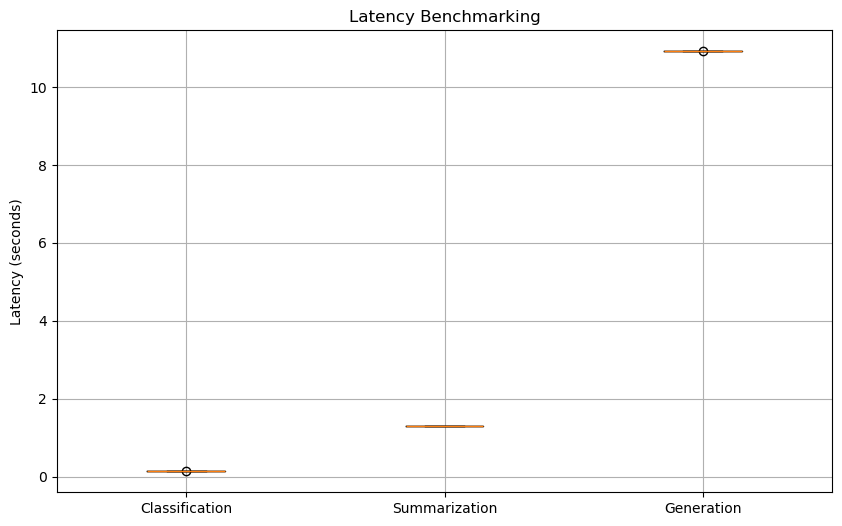

In [29]:
# Visualize the results using a box plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([classification_latencies, summarization_latencies, generation_latencies])
plt.xticks([1, 2, 3], ['Classification', 'Summarization', 'Generation'])
plt.ylabel('Latency (seconds)')
plt.title('Latency Benchmarking')
plt.grid(True)
plt.show()

In [30]:
# Print the summary statistics
import numpy as np

print("Classification latency:")
print(f"  Average: {np.mean(classification_latencies):.2f} seconds")
print(f"  Min: {np.min(classification_latencies):.2f} seconds")
print(f"  Max: {np.max(classification_latencies):.2f} seconds")
print(f"  Standard deviation: {np.std(classification_latencies):.2f} seconds")

print("\nSummarization latency:")
print(f"  Average: {np.mean(summarization_latencies):.2f} seconds")
print(f"  Min: {np.min(summarization_latencies):.2f} seconds")
print(f"  Max: {np.max(summarization_latencies):.2f} seconds")
print(f"  Standard deviation: {np.std(summarization_latencies):.2f} seconds")

print("\nGeneration latency:")
print(f"  Average: {np.mean(generation_latencies):.2f} seconds")
print(f"  Min: {np.min(generation_latencies):.2f} seconds")
print(f"  Max: {np.max(generation_latencies):.2f} seconds")
print(f"  Standard deviation: {np.std(generation_latencies):.2f} seconds")

Classification latency:
  Average: 0.14 seconds
  Min: 0.14 seconds
  Max: 0.14 seconds
  Standard deviation: 0.00 seconds

Summarization latency:
  Average: 1.30 seconds
  Min: 1.30 seconds
  Max: 1.30 seconds
  Standard deviation: 0.00 seconds

Generation latency:
  Average: 10.91 seconds
  Min: 10.91 seconds
  Max: 10.92 seconds
  Standard deviation: 0.00 seconds


### Benchmark for Resource Utilization
Let's see how much of the memory, GPU, and CPU are used before we perform optimizations on the model.

In [ ]:
!pip install psutil gputil

In [49]:
import psutil
import GPUtil

In [50]:
def measure_resource_utilization(model, tokenizer, prompt, max_new_tokens, num_iterations=10):
    memory_usages = []
    gpu_usages = []
    cpu_usages = []

    for _ in range(num_iterations):
        # Measure memory usage
        memory_usage = psutil.Process().memory_info().rss / (1024 * 1024)  # MB
        memory_usages.append(memory_usage)

        # Measure GPU usage
        gpu = GPUtil.getGPUs()[0]
        gpu_usage = gpu.load * 100
        gpu_usages.append(gpu_usage)

        # Measure CPU usage
        cpu_usage = psutil.cpu_percent()
        cpu_usages.append(cpu_usage)

        # Generate a sample to simulate the model's usage
        _ = generate_sample(prompt, model, tokenizer, max_new_tokens)

        time.sleep(0.1)  # Wait for a short interval before the next measurement

    return memory_usages, gpu_usages, cpu_usages

In [51]:
num_iterations = 10

print("Measuring resource utilization for classification...")
classification_memory, classification_gpu, classification_cpu = measure_resource_utilization(
    model, tokenizer, classification_prompt, max_new_tokens=3, num_iterations=num_iterations)

print("Measuring resource utilization for summarization...")
summarization_memory, summarization_gpu, summarization_cpu = measure_resource_utilization(
    model, tokenizer, summarization_prompt, max_new_tokens=30, num_iterations=num_iterations)

print("Measuring resource utilization for generation...")
generation_memory, generation_gpu, generation_cpu = measure_resource_utilization(
    model, tokenizer, generation_prompt, max_new_tokens=300, num_iterations=num_iterations)

Measuring resource utilization for classification...
Measuring resource utilization for summarization...
Measuring resource utilization for generation...


In [52]:
print("Average resource utilization for classification:")
print(f"Memory: {sum(classification_memory) / num_iterations:.2f} MB")
print(f"GPU: {sum(classification_gpu) / num_iterations:.2f}%")
print(f"CPU: {sum(classification_cpu) / num_iterations:.2f}%")
print()

print("Average resource utilization for summarization:")
print(f"Memory: {sum(summarization_memory) / num_iterations:.2f} MB")
print(f"GPU: {sum(summarization_gpu) / num_iterations:.2f}%")
print(f"CPU: {sum(summarization_cpu) / num_iterations:.2f}%")
print()

print("Average resource utilization for generation:")
print(f"Memory: {sum(generation_memory) / num_iterations:.2f} MB")
print(f"GPU: {sum(generation_gpu) / num_iterations:.2f}%")
print(f"CPU: {sum(generation_cpu) / num_iterations:.2f}%")

Average resource utilization for classification:
Memory: 2715.69 MB
GPU: 42.70%
CPU: 3.58%

Average resource utilization for summarization:
Memory: 2715.69 MB
GPU: 76.40%
CPU: 5.64%

Average resource utilization for generation:
Memory: 2715.69 MB
GPU: 77.40%
CPU: 6.38%


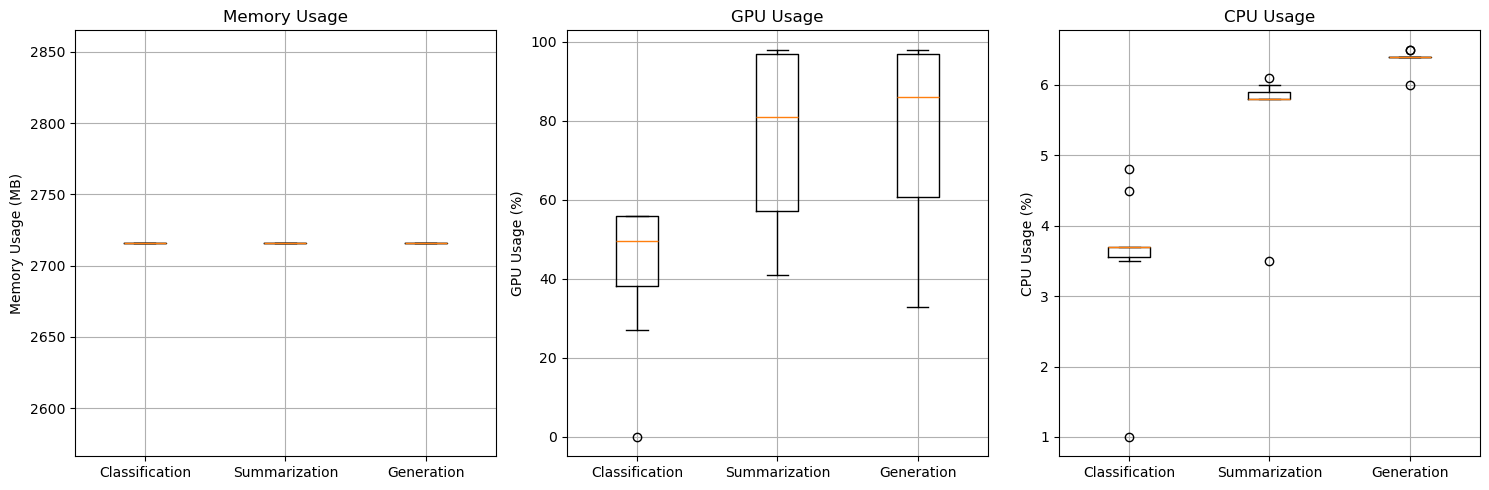

In [53]:
# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot memory usage
ax1.boxplot([classification_memory, summarization_memory, generation_memory])
ax1.set_xticklabels(['Classification', 'Summarization', 'Generation'])
ax1.set_ylabel('Memory Usage (MB)')
ax1.set_title('Memory Usage')
ax1.grid(True)

# Plot GPU usage
ax2.boxplot([classification_gpu, summarization_gpu, generation_gpu])
ax2.set_xticklabels(['Classification', 'Summarization', 'Generation'])
ax2.set_ylabel('GPU Usage (%)')
ax2.set_title('GPU Usage')
ax2.grid(True)

# Plot CPU usage
ax3.boxplot([classification_cpu, summarization_cpu, generation_cpu])
ax3.set_xticklabels(['Classification', 'Summarization', 'Generation'])
ax3.set_ylabel('CPU Usage (%)')
ax3.set_title('CPU Usage')
ax3.grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### TODO: Maybe I can incorporate the resource utilization measurements into the latency benchmarking, since it's already running of all those prompts